In [1]:
!pip install catboost
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
!pip install shap
import shap
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.1 MB/s eta 0:00:00


In [2]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
parquet_path = '/content/drive/MyDrive/Data Science CapstoneProject/Bicing_Capstone/5. MODEL/data_features.parquet'
parquet_path_predict = '/content/drive/MyDrive/Data Science CapstoneProject/Bicing_Capstone/5. MODEL/predict_data.parquet'

In [5]:
df = pd.read_parquet(parquet_path)
df_predict = pd.read_parquet(parquet_path_predict)

In [6]:
df.columns

Index(['station_id', 'month', 'day', 'hour', 'year',
       'percentage_docks_available', 'ctx_4', 'ctx_3', 'ctx_2', 'ctx_1',
       'capacity', 'lat', 'lon', 'altitude', 'month_sin', 'month_cos',
       'hour_sin', 'hour_cos', 'categoria_temperatura',
       'categoria_precipitacion'],
      dtype='object')

In [7]:
df_predict.columns

Index(['station_id', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2',
       'ctx-1', 'capacity', 'lat', 'lon', 'altitude', 'year', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'categoria_temperatura',
       'categoria_precipitacion'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12083770 entries, 4 to 12085793
Data columns (total 20 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  int64  
 1   month                       int32  
 2   day                         int32  
 3   hour                        int32  
 4   year                        int64  
 5   percentage_docks_available  float64
 6   ctx_4                       float64
 7   ctx_3                       float64
 8   ctx_2                       float64
 9   ctx_1                       float64
 10  capacity                    int64  
 11  lat                         float64
 12  lon                         float64
 13  altitude                    float64
 14  month_sin                   float64
 15  month_cos                   float64
 16  hour_sin                    float64
 17  hour_cos                    float64
 18  categoria_temperatura       object 
 19  categoria_precipitacion 

In [9]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171902 entries, 0 to 171901
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   station_id               171902 non-null  int64  
 1   month                    171902 non-null  int64  
 2   day                      171902 non-null  int64  
 3   hour                     171902 non-null  int64  
 4   ctx-4                    171902 non-null  float64
 5   ctx-3                    171902 non-null  float64
 6   ctx-2                    171902 non-null  float64
 7   ctx-1                    171902 non-null  float64
 8   capacity                 171902 non-null  int64  
 9   lat                      171902 non-null  float64
 10  lon                      171902 non-null  float64
 11  altitude                 171902 non-null  float64
 12  year                     171902 non-null  int64  
 13  month_sin                171902 non-null  float64
 14  mont

In [10]:
df.groupby(['year','month'])['year'].count()

year  month
2021  1        371075
      2        332033
      3          1514
      4        362591
      5        373764
      6        355151
      7        367522
      8        372695
      9        361917
      10       373001
      11       357454
      12       365295
2022  1        365034
      2        338206
      3          1515
      4        362718
      5        374715
      6        361799
      7        373838
      8        372142
      9        360617
      10       372534
      11       359108
      12       372874
2023  1        336398
      2        335611
      3        356250
      4        300124
      5        352115
      6        351700
      7        375944
      8        257169
      9        310285
      10       371218
      11       353906
      12       373938
Name: year, dtype: int64

In [11]:
df_predict.groupby(['year','month'])['year'].count()

year  month
2024  1        57340
      2        55467
      3        59095
Name: year, dtype: int64

In [12]:
df_predict.groupby(['station_id'])['year'].count()

station_id
1      431
2      430
3      432
4      431
5      425
      ... 
474    431
492    432
494    431
495    432
496    432
Name: year, Length: 399, dtype: int64

In [13]:
df.groupby(['station_id'])['year'].count()

station_id
1      24029
2      23461
3      24077
4      24061
5      23759
       ...  
515    24066
516    23799
517    23978
518    24069
519    24008
Name: year, Length: 506, dtype: int64

In [14]:
#df = df.drop(columns=['year'],axis=1)
df_predict = df_predict.drop(columns=['year'],axis=1)

In [15]:
# Dividir el conjunto de datos en dos partes: antes y después de la segunda mitad de 2023
df_train = df[(df['year'] == 2022) | ((df['year'] == 2023) & (df['month'] <= 7))]
df_test = df[(df['year'] == 2023) & (df['month'] > 7)]

# Dividir los datos en características (X) y variable objetivo (y) para cada conjunto
X_train = df_train.drop(columns=['percentage_docks_available'])
y_train = df_train['percentage_docks_available']

X_test = df_test.drop(columns=['percentage_docks_available'])
y_test = df_test['percentage_docks_available']


In [16]:
X_train = X_train.drop(columns=['year'],axis=1)
X_test = X_test.drop(columns=['year'],axis=1)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6423242, 18)
(6423242,)
(1666516, 18)
(1666516,)


In [18]:
print(round(len(X_test)/len(X_train),3))

0.259


In [19]:
X_train

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_temperatura,categoria_precipitacion
7956,1,1,1,0,0.74,0.71,0.64,0.62,45,41.397978,2.180107,16.0,0.5,0.866025,-0.258819,9.659258e-01,Fresco,No llueve
7957,1,1,1,1,0.71,0.64,0.62,0.70,45,41.397978,2.180107,16.0,0.5,0.866025,0.000000,1.000000e+00,Fresco,No llueve
7958,1,1,1,2,0.64,0.62,0.70,0.74,45,41.397978,2.180107,16.0,0.5,0.866025,0.258819,9.659258e-01,Fresco,No llueve
7959,1,1,1,3,0.62,0.70,0.74,0.75,45,41.397978,2.180107,16.0,0.5,0.866025,0.500000,8.660254e-01,Fresco,No llueve
7960,1,1,1,4,0.70,0.74,0.75,0.73,45,41.397978,2.180107,16.0,0.5,0.866025,0.707107,7.071068e-01,Fresco,No llueve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12082465,519,7,31,19,0.91,0.91,0.86,0.75,24,41.424655,2.166289,110.0,-0.5,-0.866025,-1.000000,-1.836970e-16,Cálido,No llueve
12082466,519,7,31,20,0.91,0.86,0.75,0.68,24,41.424655,2.166289,110.0,-0.5,-0.866025,-0.965926,2.588190e-01,Cálido,No llueve
12082467,519,7,31,21,0.86,0.75,0.68,0.83,24,41.424655,2.166289,110.0,-0.5,-0.866025,-0.866025,5.000000e-01,Cálido,No llueve
12082468,519,7,31,22,0.75,0.68,0.83,0.80,24,41.424655,2.166289,110.0,-0.5,-0.866025,-0.707107,7.071068e-01,Cálido,No llueve


In [20]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [21]:
"""for column in ['categoria_temperatura','categoria_precipitacion']:
        X_train = onehot_encode(X_train, column=column)
        X_test = onehot_encode(X_test, column=column)
        df_predict = onehot_encode(df_predict, column=column)"""


"for column in ['categoria_temperatura','categoria_precipitacion']:\n        X_train = onehot_encode(X_train, column=column)\n        X_test = onehot_encode(X_test, column=column)\n        df_predict = onehot_encode(df_predict, column=column)"

In [22]:
"""X_test['categoria_temperatura_Caluroso'] = 0
X_test = X_test[X_train.columns]"""

"X_test['categoria_temperatura_Caluroso'] = 0\nX_test = X_test[X_train.columns]"

In [23]:
print("Columns in X_train:")
print(X_train.columns)

print("Columns in X_test:")
print(X_test.columns)

print("Columns in predict:")
print(df_predict.columns)

Columns in X_train:
Index(['station_id', 'month', 'day', 'hour', 'ctx_4', 'ctx_3', 'ctx_2',
       'ctx_1', 'capacity', 'lat', 'lon', 'altitude', 'month_sin', 'month_cos',
       'hour_sin', 'hour_cos', 'categoria_temperatura',
       'categoria_precipitacion'],
      dtype='object')
Columns in X_test:
Index(['station_id', 'month', 'day', 'hour', 'ctx_4', 'ctx_3', 'ctx_2',
       'ctx_1', 'capacity', 'lat', 'lon', 'altitude', 'month_sin', 'month_cos',
       'hour_sin', 'hour_cos', 'categoria_temperatura',
       'categoria_precipitacion'],
      dtype='object')
Columns in predict:
Index(['station_id', 'month', 'day', 'hour', 'ctx-4', 'ctx-3', 'ctx-2',
       'ctx-1', 'capacity', 'lat', 'lon', 'altitude', 'month_sin', 'month_cos',
       'hour_sin', 'hour_cos', 'categoria_temperatura',
       'categoria_precipitacion'],
      dtype='object')


In [24]:
X_train = X_train.drop(columns=['categoria_temperatura'],axis=1)
X_test = X_test.drop(columns=['categoria_temperatura'],axis=1)
df_predict = df_predict.drop(columns=['categoria_temperatura'],axis=1)

In [25]:
X_train['categoria_precipitacion'] = X_train['categoria_precipitacion'].apply(lambda x: 0 if x == 'No llueve' else 1)
X_test['categoria_precipitacion'] = X_test['categoria_precipitacion'].apply(lambda x: 0 if x == 'No llueve' else 1)
df_predict['categoria_precipitacion'] = df_predict['categoria_precipitacion'].apply(lambda x: 0 if x == 'No llueve' else 1)

In [26]:
X_train['categoria_precipitacion'].value_counts()

categoria_precipitacion
1    4128779
0    2294463
Name: count, dtype: int64

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("Datos de entrenamiento escalados:")
print(X_train_scaled.shape)

print("Datos de prueba escalados:")
print(X_test_scaled.shape)

Datos de entrenamiento escalados:
(6423242, 17)
Datos de prueba escalados:
(1666516, 17)


In [28]:
X_train_scaled

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion
7956,-1.745035,-1.472213,-1.677493,-1.668907,0.579268,0.466437,0.203184,0.127956,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,-0.364727,1.372868,-1.341437
7957,-1.745035,-1.472213,-1.677493,-1.524128,0.466453,0.203200,0.127973,0.428800,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,0.001097,1.421084,-1.341437
7958,-1.745035,-1.472213,-1.677493,-1.379350,0.203217,0.127989,0.428816,0.579222,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,0.366920,1.372868,-1.341437
7959,-1.745035,-1.472213,-1.677493,-1.234571,0.128007,0.428832,0.579238,0.616828,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,0.707814,1.231507,-1.341437
7960,-1.745035,-1.472213,-1.677493,-1.089792,0.428848,0.579253,0.616843,0.541617,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,1.000546,1.006634,-1.341437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12082465,1.728301,0.364761,1.755060,1.081890,1.218555,1.218543,1.030502,0.616828,-0.464824,1.180510,-0.084287,2.311699,-0.908081,-1.036339,-1.412339,0.006064,-1.341437
12082466,1.728301,0.364761,1.755060,1.226669,1.218555,1.030516,0.616843,0.353589,-0.464824,1.180510,-0.084287,2.311699,-0.908081,-1.036339,-1.364177,0.372298,-1.341437
12082467,1.728301,0.364761,1.755060,1.371447,1.030530,0.616858,0.353605,0.917671,-0.464824,1.180510,-0.084287,2.311699,-0.908081,-1.036339,-1.222974,0.713574,-1.341437
12082468,1.728301,0.364761,1.755060,1.516226,0.616873,0.353621,0.917686,0.804855,-0.464824,1.180510,-0.084287,2.311699,-0.908081,-1.036339,-0.998353,1.006634,-1.341437


In [29]:
print("\nTraining CatBoost...")
catboost_reg = CatBoostRegressor(
    iterations=13500,
    depth=8,
    learning_rate=0.05,
    boosting_type='Plain',
    task_type='GPU',
    devices='0:1',
    verbose=400,
    random_strength=12,
    l2_leaf_reg=8,
    bagging_temperature=1.5
)
catboost_reg.fit(X_train_scaled, y_train)
train_score_catboost = catboost_reg.score(X_train_scaled, y_train)
test_score_catboost = catboost_reg.score(X_test_scaled, y_test)
y_pred_train_catboost = catboost_reg.predict(X_train_scaled)
y_pred_test_catboost = catboost_reg.predict(X_test_scaled)
rmse_train_catboost = calculate_rmse(y_train, y_pred_train_catboost)
rmse_test_catboost = calculate_rmse(y_test, y_pred_test_catboost)
print("CatBoost: Train Score =", train_score_catboost, ", Test Score =", test_score_catboost)
print("CatBoost: RMSE Train =", rmse_train_catboost, ", RMSE Test =", rmse_test_catboost)


Training CatBoost...
0:	learn: 0.2555645	total: 225ms	remaining: 50m 31s
400:	learn: 0.1000571	total: 26.7s	remaining: 14m 32s
800:	learn: 0.0984504	total: 52.8s	remaining: 13m 57s
1200:	learn: 0.0976025	total: 1m 18s	remaining: 13m 27s
1600:	learn: 0.0970479	total: 1m 43s	remaining: 12m 50s
2000:	learn: 0.0966151	total: 2m 9s	remaining: 12m 24s
2400:	learn: 0.0962901	total: 2m 35s	remaining: 11m 59s
2800:	learn: 0.0960063	total: 3m 1s	remaining: 11m 32s
3200:	learn: 0.0957602	total: 3m 27s	remaining: 11m 8s
3600:	learn: 0.0955528	total: 3m 53s	remaining: 10m 41s
4000:	learn: 0.0953653	total: 4m 18s	remaining: 10m 12s
4400:	learn: 0.0951912	total: 4m 43s	remaining: 9m 45s
4800:	learn: 0.0950332	total: 5m 9s	remaining: 9m 20s
5200:	learn: 0.0948864	total: 5m 35s	remaining: 8m 55s
5600:	learn: 0.0947505	total: 6m 4s	remaining: 8m 34s
6000:	learn: 0.0946210	total: 6m 34s	remaining: 8m 13s
6400:	learn: 0.0944937	total: 7m	remaining: 7m 46s
6800:	learn: 0.0943709	total: 7m 26s	remaining: 7

0:	learn: 0.2555645	test: 0.2490961	best: 0.2490961 (0)	total: 86ms	remaining: 19m 20s
400:	learn: 0.1000571	test: 0.0942791	best: 0.0942791 (400)	total: 27.3s	remaining: 14m 52s
800:	learn: 0.0984504	test: 0.0931826	best: 0.0931826 (800)	total: 54.5s	remaining: 14m 24s
1200:	learn: 0.0976025	test: 0.0926508	best: 0.0926508 (1200)	total: 1m 21s	remaining: 13m 52s
1600:	learn: 0.0970479	test: 0.0923722	best: 0.0923722 (1600)	total: 1m 48s	remaining: 13m 26s
2000:	learn: 0.0966151	test: 0.0921909	best: 0.0921909 (2000)	total: 2m 15s	remaining: 12m 56s
2400:	learn: 0.0962901	test: 0.0920620	best: 0.0920620 (2400)	total: 2m 41s	remaining: 12m 27s
2800:	learn: 0.0960063	test: 0.0919578	best: 0.0919578 (2800)	total: 3m 10s	remaining: 12m 8s
3200:	learn: 0.0957602	test: 0.0918787	best: 0.0918774 (3189)	total: 3m 38s	remaining: 11m 42s
3600:	learn: 0.0955528	test: 0.0918167	best: 0.0918167 (3589)	total: 4m 4s	remaining: 11m 13s
4000:	learn: 0.0953653	test: 0.0917679	best: 0.0917666 (3992)	tota

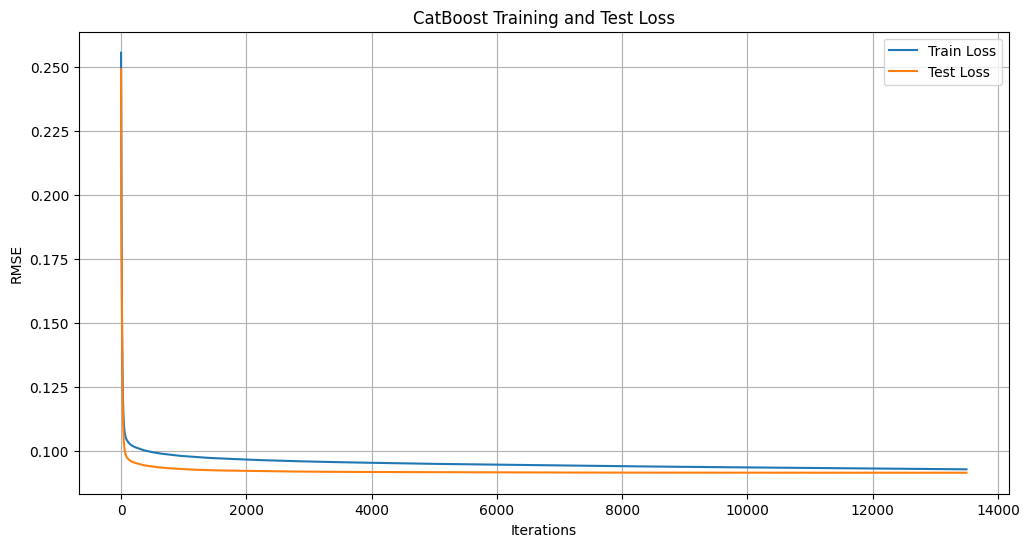

In [37]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool# Train the model
train_pool = Pool(X_train_scaled, y_train)
test_pool = Pool(X_test_scaled, y_test)

catboost_reg.fit(train_pool, eval_set=test_pool)

# Get training and evaluation log
train_log = catboost_reg.get_evals_result()

# Extract loss values
train_loss = train_log['learn']['RMSE']
test_loss = train_log['validation']['RMSE']

# Plot the training and test loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('CatBoost Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

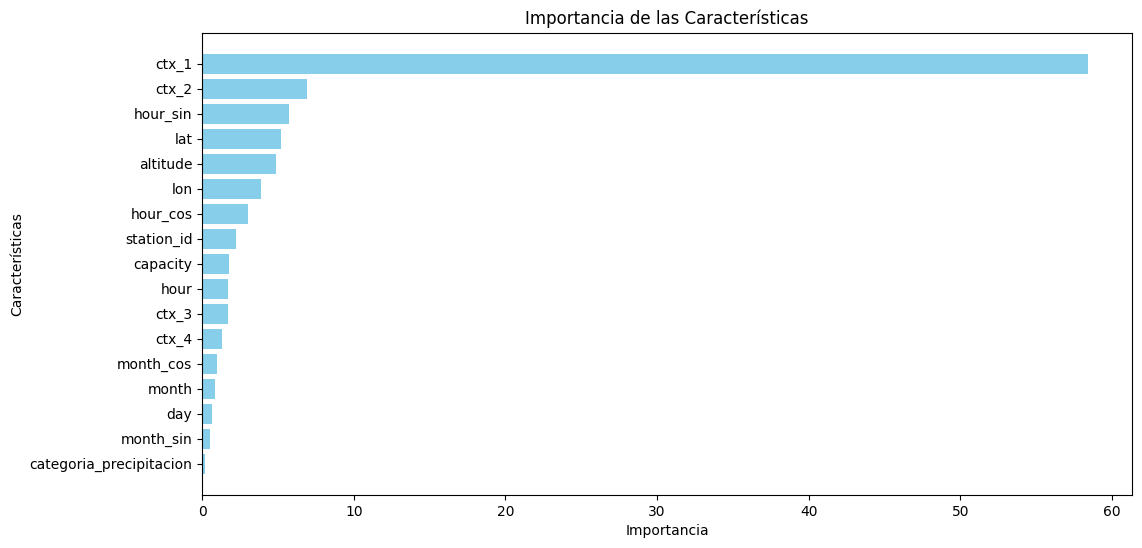

In [38]:
# Obtén la importancia de las características
feature_importances = catboost_reg.get_feature_importance(Pool(X_train_scaled, y_train))
feature_names = X_train_scaled.columns

# Crea un DataFrame para visualizar mejor
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualiza la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()  # Invierte el eje y para que la característica más importante esté en la parte superior
plt.show()

In [30]:
save_path = '/content/drive/MyDrive/Data Science CapstoneProject/Bicing_Capstone/5. MODEL/catboost_model.cbm'
catboost_reg.save_model(save_path)

In [31]:
import pandas as pd
import numpy as np

# Supongamos que ya has entrenado el modelo y tienes las predicciones en y_pred_test_catboost

# Asegúrate de que y_test es un DataFrame con los mismos índices que X_test
if isinstance(y_test, pd.Series):
    y_test_df = y_test.to_frame(name='Real')
elif isinstance(y_test, np.ndarray):
    y_test_df = pd.DataFrame(y_test, index=X_test.index, columns=['Real'])
else:
    y_test_df = y_test.copy()
    y_test_df.columns = ['Real']

# Convertir y_pred_test_catboost a un DataFrame y asegurarse de que usa los mismos índices que X_test
y_pred_test_df = pd.DataFrame(y_pred_test_catboost, index=X_test.index, columns=['Prediccion'])

# Crear un DataFrame con las características del conjunto de prueba original
X_test_original_df = X_test.copy()

# Concatenar los DataFrames en uno solo
df_predictions = pd.concat([X_test_original_df, y_test_df, y_pred_test_df], axis=1)

# Opcional: mostrar las primeras filas del DataFrame para una visualización más clara
df_predictions.head()


,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion,Real,Prediccion
20709,1,8,1,0,0.32,0.31,0.27,0.16,45,41.397978,2.180107,16.0,-0.866025,-0.5,-0.258819,0.965926,0,0.19,0.153896
20710,1,8,1,1,0.31,0.27,0.16,0.19,45,41.397978,2.180107,16.0,-0.866025,-0.5,0.000000,1.000000,0,0.22,0.201478
20711,1,8,1,2,0.27,0.16,0.19,0.22,45,41.397978,2.180107,16.0,-0.866025,-0.5,0.258819,0.965926,0,0.23,0.223438
20712,1,8,1,3,0.16,0.19,0.22,0.23,45,41.397978,2.180107,16.0,-0.866025,-0.5,0.500000,0.866025,0,0.24,0.243165
20713,1,8,1,4,0.19,0.22,0.23,0.24,45,41.397978,2.180107,16.0,-0.866025,-0.5,0.707107,0.707107,0,0.23,0.260524


In [32]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1666516 entries, 20709 to 12085793
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   station_id               1666516 non-null  int64  
 1   month                    1666516 non-null  int32  
 2   day                      1666516 non-null  int32  
 3   hour                     1666516 non-null  int32  
 4   ctx_4                    1666516 non-null  float64
 5   ctx_3                    1666516 non-null  float64
 6   ctx_2                    1666516 non-null  float64
 7   ctx_1                    1666516 non-null  float64
 8   capacity                 1666516 non-null  int64  
 9   lat                      1666516 non-null  float64
 10  lon                      1666516 non-null  float64
 11  altitude                 1666516 non-null  float64
 12  month_sin                1666516 non-null  float64
 13  month_cos                1666516 non-null 

In [33]:
df_predictions['Error'] = (df_predictions['Real'] - df_predictions['Prediccion']).abs()
error_by_station_day = df_predictions.groupby(['station_id'])['Error'].mean().reset_index()

In [34]:
error_by_station_day

,station_id,Error
0,1,0.047182
1,2,0.060343
2,3,0.063287
3,4,0.092245
4,5,0.033565
...,...,...
501,515,0.036045
502,516,0.040453
503,517,0.032244
504,518,0.026416


In [35]:
top_errors = error_by_station_day.sort_values(by='Error', ascending=False).tail(15)
top_station_ids = top_errors['station_id'].tolist()
top_station_ids

[258, 491, 301, 474, 481, 271, 458, 518, 463, 268, 459, 270, 269, 10, 473]

In [ ]:
df_predictions[df_predictions['station_id']==230]

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion,Real,Prediccion,Error
5267959,230,8,1,0,0.48,0.51,0.62,0.56,26,41.405936,2.151798,80.0,-8.660254e-01,-0.5,-0.258819,9.659258e-01,0,0.51,0.478514,0.031486
5267960,230,8,1,1,0.51,0.62,0.56,0.51,26,41.405936,2.151798,80.0,-8.660254e-01,-0.5,0.000000,1.000000e+00,0,0.69,0.476400,0.213600
5267961,230,8,1,2,0.62,0.56,0.51,0.69,26,41.405936,2.151798,80.0,-8.660254e-01,-0.5,0.258819,9.659258e-01,0,0.65,0.617252,0.032748
5267962,230,8,1,3,0.56,0.51,0.69,0.65,26,41.405936,2.151798,80.0,-8.660254e-01,-0.5,0.500000,8.660254e-01,0,0.66,0.553975,0.106025
5267963,230,8,1,4,0.51,0.69,0.65,0.66,26,41.405936,2.151798,80.0,-8.660254e-01,-0.5,0.707107,7.071068e-01,0,0.64,0.606106,0.033894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271278,230,12,31,19,0.75,0.81,0.86,0.79,26,41.405936,2.151798,80.0,-2.449294e-16,1.0,-1.000000,-1.836970e-16,0,0.58,0.583113,0.003113
5271279,230,12,31,20,0.81,0.86,0.79,0.58,26,41.405936,2.151798,80.0,-2.449294e-16,1.0,-0.965926,2.588190e-01,0,0.48,0.455661,0.024339
5271280,230,12,31,21,0.86,0.79,0.58,0.48,26,41.405936,2.151798,80.0,-2.449294e-16,1.0,-0.866025,5.000000e-01,0,0.46,0.497007,0.037007
5271281,230,12,31,22,0.79,0.58,0.48,0.46,26,41.405936,2.151798,80.0,-2.449294e-16,1.0,-0.707107,7.071068e-01,0,0.45,0.488860,0.038860


### PREDICT


In [ ]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171902 entries, 0 to 171901
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   station_id               171902 non-null  int64  
 1   month                    171902 non-null  int64  
 2   day                      171902 non-null  int64  
 3   hour                     171902 non-null  int64  
 4   ctx-4                    171902 non-null  float64
 5   ctx-3                    171902 non-null  float64
 6   ctx-2                    171902 non-null  float64
 7   ctx-1                    171902 non-null  float64
 8   capacity                 171902 non-null  int64  
 9   lat                      171902 non-null  float64
 10  lon                      171902 non-null  float64
 11  altitude                 171902 non-null  float64
 12  month_sin                171902 non-null  float64
 13  month_cos                171902 non-null  float64
 14  hour

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6423242 entries, 7956 to 12082469
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   station_id               int64  
 1   month                    int32  
 2   day                      int32  
 3   hour                     int32  
 4   ctx_4                    float64
 5   ctx_3                    float64
 6   ctx_2                    float64
 7   ctx_1                    float64
 8   capacity                 int64  
 9   lat                      float64
 10  lon                      float64
 11  altitude                 float64
 12  month_sin                float64
 13  month_cos                float64
 14  hour_sin                 float64
 15  hour_cos                 float64
 16  categoria_precipitacion  int64  
dtypes: float64(11), int32(3), int64(3)
memory usage: 808.6 MB


In [ ]:
df_predict.rename(columns={'ctx-4': 'ctx_4', 'ctx-3': 'ctx_3', 'ctx-2': 'ctx_2', 'ctx-1': 'ctx_1'}, inplace=True)


In [ ]:
df_predict

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion
0,1,1,1,5,0.781481,0.677778,0.696296,0.750000,45,41.397978,2.180107,16.0,0.5,8.660254e-01,0.866025,0.500000,0
1,1,1,1,10,0.737374,0.711111,0.711111,0.731624,45,41.397978,2.180107,16.0,0.5,8.660254e-01,0.707107,-0.707107,0
2,1,1,1,15,0.827778,0.896296,0.901852,0.883333,45,41.397978,2.180107,16.0,0.5,8.660254e-01,-0.500000,-0.866025,0
3,1,1,1,20,0.825926,0.874074,0.927778,0.918519,45,41.397978,2.180107,16.0,0.5,8.660254e-01,-0.965926,0.258819,0
4,1,1,2,1,0.712963,0.777778,0.814815,0.790741,45,41.397978,2.180107,16.0,0.5,8.660254e-01,0.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171897,496,3,31,1,0.828704,0.787037,0.777778,0.853535,18,41.404862,2.174799,33.0,1.0,6.123234e-17,0.000000,1.000000,1
171898,496,3,31,6,0.930556,0.944444,0.935185,0.856481,18,41.404862,2.174799,33.0,1.0,6.123234e-17,0.965926,0.258819,1
171899,496,3,31,11,0.912037,0.884259,0.518519,0.157407,18,41.404862,2.174799,33.0,1.0,6.123234e-17,0.500000,-0.866025,1
171900,496,3,31,16,0.245370,0.319444,0.277778,0.305556,18,41.404862,2.174799,33.0,1.0,6.123234e-17,-0.707107,-0.707107,1


In [ ]:
X_train_scaled.head(1)

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion
7956,-1.745035,-1.472213,-1.677493,-1.668907,0.579268,0.466437,0.203184,0.127956,2.693991,-0.086242,0.481227,-0.59471,0.594787,1.332404,-0.364727,1.372868,-1.341437


In [ ]:
# Escala los datos de predicción utilizando el mismo scaler que usaste para los datos de entrenamiento
X_predict_scaled = scaler.transform(df_predict)

# Si quieres que tus datos de predicción también sean un DataFrame de pandas, puedes hacerlo así:
X_predict_scaled = pd.DataFrame(X_predict_scaled, index=df_predict.index, columns=df_predict.columns)

In [ ]:
X_predict_scaled

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,capacity,lat,lon,altitude,month_sin,month_cos,hour_sin,hour_cos,categoria_precipitacion
0,-1.745035,-1.472213,-1.677493,-0.945013,0.735260,0.345264,0.414888,0.616828,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,1.225167,0.713574,-1.341437
1,-1.745035,-1.472213,-1.677493,-0.221119,0.569392,0.470615,0.470600,0.547723,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,1.000546,-0.994506,-1.341437
2,-1.745035,-1.472213,-1.677493,0.502775,0.909358,1.167009,1.187888,1.118234,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,-0.705621,-1.219379,-1.341437
3,-1.745035,-1.472213,-1.677493,1.226669,0.902394,1.083442,1.285383,1.250550,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,-1.364177,0.372298,-1.341437
4,-1.745035,-1.472213,-1.563075,-1.524128,0.477595,0.721317,0.860582,0.770035,2.693991,-0.086242,0.481227,-0.594710,0.594787,1.332404,0.001097,1.421084,-1.341437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171897,1.574080,-0.859888,1.755060,-1.524128,0.912839,0.756137,0.721302,1.006177,-1.367343,0.240663,0.263995,-0.069083,1.346222,0.148032,0.001097,1.421084,0.745469
171898,1.574080,-0.859888,1.755060,-0.800234,1.295855,1.348072,1.313239,1.017256,-1.367343,0.240663,0.263995,-0.069083,1.346222,0.148032,1.366370,0.372298,0.745469
171899,1.574080,-0.859888,1.755060,-0.076340,1.226215,1.121744,-0.253652,-1.611646,-1.367343,0.240663,0.263995,-0.069083,1.346222,0.148032,0.707814,-1.219379,0.745469
171900,1.574080,-0.859888,1.755060,0.647554,-1.280792,-1.002258,-1.158968,-1.054528,-1.367343,0.240663,0.263995,-0.069083,1.346222,0.148032,-0.998353,-0.994506,0.745469


In [ ]:
predictions = catboost_reg.predict(X_predict_scaled)

In [ ]:
predictions

array([0.78177055, 0.77906907, 0.87090506, ..., 0.30550092, 0.36141598,
       0.49647298])

In [ ]:
predictions_clipped = np.clip(predictions, a_min=None, a_max=1)

In [ ]:
predictions_clipped

array([0.78177055, 0.77906907, 0.87090506, ..., 0.30550092, 0.36141598,
       0.49647298])

In [ ]:
submission_df = pd.DataFrame({'index': df_predict.index, 'percentage_docks_available': predictions_clipped})

# Guardamos el DataFrame en un archivo CSV


submission_df.to_csv('/content/drive/MyDrive/Data Science CapstoneProject/Bicing_Capstone/5. MODEL/Submission Samples/submission.csv', index=False)

In [ ]:
submission_df[submission_df['percentage_docks_available']>1]

,index,percentage_docks_available


In [ ]:
submission_df

,index,percentage_docks_available
0,0,0.778288
1,1,0.780620
2,2,0.870664
3,3,0.846584
4,4,0.769138
...,...,...
171897,171897,0.773173
171898,171898,0.736345
171899,171899,0.338241
171900,171900,0.399352


In [ ]:
csv_save_path = '/content/drive/MyDrive/Data Science CapstoneProject/Bicing_Capstone/5. MODEL/predictions_test.csv'

# Guardar el DataFrame filtrado como un archivo CSV
df_predict .to_csv(csv_save_path, index=False)